# **Part IV: Sentiment analysis using LSTM**

# **1: Data exploration and preprocessing.**

In [ ]:
#importing required libraries
import pandas as pd
import json
import os
import glob
import warnings
warnings.simplefilter("ignore")
import tarfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import random
import nltk
from torchtext.data.utils import get_tokenizer
import time
from collections import Counter

In [ ]:
# Setting seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In this part, I chose Stanford Large Movie Review Dataset (IMDb) and preprocessed it for training a sentiment analysis model. The dataset contains movie reviews labeled as either positive or negative sentiment.

In [ ]:
# Loading the Dataset and Printing Main Statistics
file_path = "/content/aclImdb_v1.tar.gz"

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path="/content")

print("Extracted files:")
!ls /content/aclImdb



Extracted files:
imdbEr.txt  imdb.vocab	README	test  train


In [ ]:
train_path = "/content/aclImdb/train"
test_path = "/content/aclImdb/test"

def load_reviews(folder_path, label):
    reviews = []
    for filename in os.listdir(folder_path):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
            reviews.append({"review": file.read(), "label": label})
    return reviews

# Loading positive and negative reviews for train and test dataset
train_pos = load_reviews(os.path.join(train_path, "pos"), 1)
train_neg = load_reviews(os.path.join(train_path, "neg"), 0)
test_pos = load_reviews(os.path.join(test_path, "pos"), 1)
test_neg = load_reviews(os.path.join(test_path, "neg"), 0)

# Combining
train_df = pd.DataFrame(train_pos + train_neg)
test_df = pd.DataFrame(test_pos + test_neg)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#Printing the first 5 rows of the dataset
print("Train Dataset:")
print(train_df.head())
print("\nTest Dataset:")
print(test_df.head())

Train Dataset:
                                              review  label
0  If you like Deep Purple, you will enjoy in thi...      1
1  Steven buddy, you remember when you said this:...      0
2  stars: Julianna Donald, Lonny Price and Louis ...      1
3  The book that this movie is based on seriously...      0
4  I didn't expect much from this TV movie. You h...      0

Test Dataset:
                                              review  label
0  A vehemently cynical, sarcastic and intense fi...      1
1  This movie should go down in the annals of fie...      0
2  Beautiful, emotional, and subtle. I watch this...      1
3  Jerry Lewis was marginally funny when he didn'...      0
4  PDQ Bach did it better. Much of "Bach"'s speak...      0


In [ ]:
#shape of the datasets
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

#class distribution
print("\nTrain class distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)
print("\nTest class distribution:")
print(test_df['label'].value_counts(normalize=True) * 100)

Train dataset shape: (25000, 2)
Test dataset shape: (25000, 2)

Train class distribution:
label
1    50.0
0    50.0
Name: proportion, dtype: float64

Test class distribution:
label
1    50.0
0    50.0
Name: proportion, dtype: float64


In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


The Stanford Large Movie Review Dataset (IMDb) is a collection of 50,000 movie reviews from IMDb, labeled as either positive (1) or negative (0) sentiment.The dataset is evenly split into 25,000 training samples and 25,000 test samples, making it a balanced dataset for binary classification. Each review is a text string, and the corresponding label indicates the sentiment expressed in the review.

In [ ]:
# Number of samples
num_samples = len(df)
print(f"Number of samples: {num_samples}")

Number of samples: 50000


In [ ]:
# Class distribution
class_distribution = df['label'].value_counts(normalize=True) * 100
print("\nClass Distribution (%):")
print(class_distribution)


Class Distribution (%):
label
1    50.0
0    50.0
Name: proportion, dtype: float64


The dataset is balanced, with 50% positive and 50% negative reviews.

### **Average review length (in words or characters).**

In [ ]:
# average review length in words
import matplotlib.pyplot as plt

avg_review_length_words = df['review'].apply(lambda x: len(x.split())).mean()
print(f"\nAverage review length (in words): {avg_review_length_words:.2f}")

# average review length in characters
avg_review_length_chars = df['review'].apply(len).mean()
print(f"Average review length (in characters): {avg_review_length_chars:.2f}")




Average review length (in words): 231.16
Average review length (in characters): 1309.43


### **Vocabulary size (number of unique words).**

In [ ]:
# Vocabulary size
from collections import Counter
all_words = ' '.join(df['review']).split()
vocab_size = len(Counter(all_words))
print(f"\nVocabulary size: {vocab_size}")


Vocabulary size: 438729


### **Checking for missing values**

In [ ]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
review                 0
label                  0
review_length_chars    0
dtype: int64


There are no missing values in the dataset, so no further handling is required.



## **Data Visualizations**

### **Histogram of review lengths (in words)**

In [ ]:
df['review'] = df['review'].str.replace('<br />', ' ', regex=False)

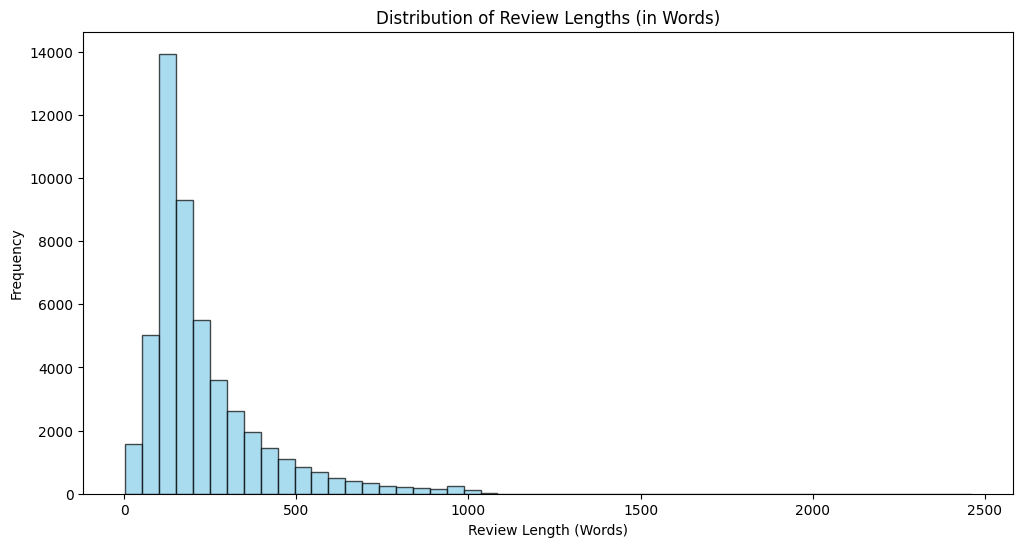

In [ ]:
review_lengths_words = df['review'].apply(lambda x: len(x.split()))
review_lengths_chars = df['review'].apply(lambda x: len(x))

plt.figure(figsize=(12, 6))
plt.hist(review_lengths_words, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Review Lengths (in Words)')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()



### **Histogram of review lengths (in characters)**

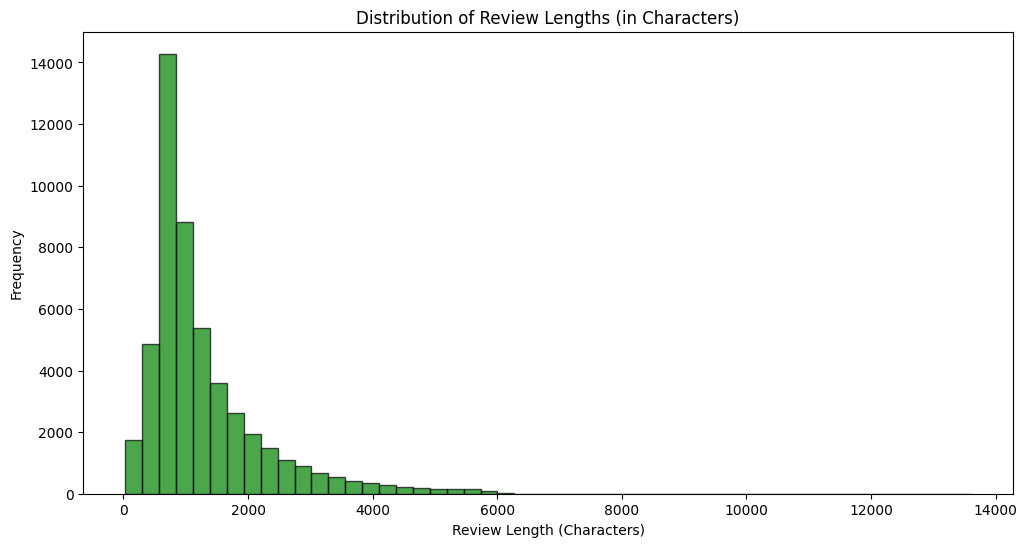

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(review_lengths_chars, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.title('Distribution of Review Lengths (in Characters)')
plt.xlabel('Review Length (Characters)')
plt.ylabel('Frequency')
plt.show()

### **Word clouds for each sentiment class**

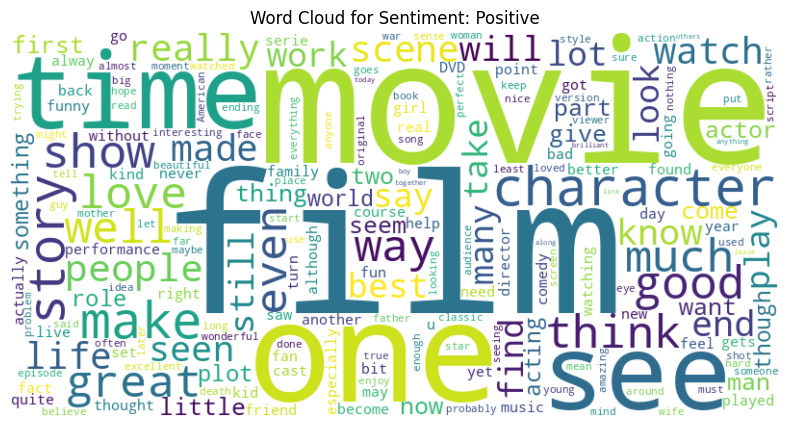

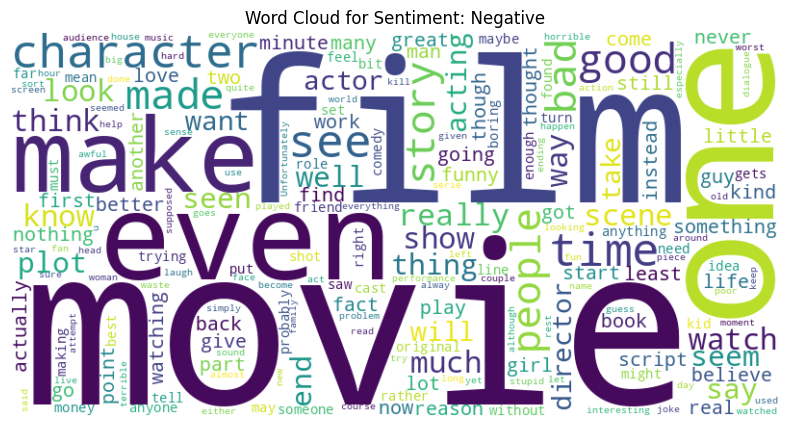

In [ ]:
from wordcloud import WordCloud

for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Sentiment: {"Positive" if label == 1 else "Negative"}')
    plt.axis('off')
    plt.show()

### **Bar chart of class distribution**

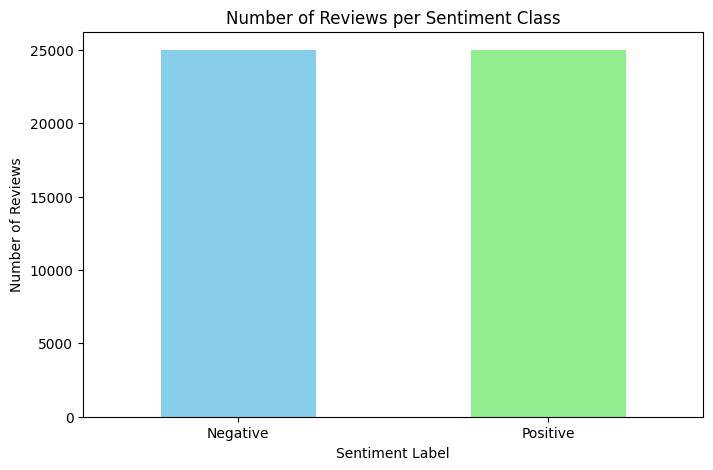

In [ ]:
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Number of Reviews per Sentiment Class')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

### **Top 20 bigrams for positive reviews**

In [ ]:
positive_reviews = ' '.join(df[df['label'] == 1]['review'])
vectorizer = CountVectorizer(ngram_range=(2, 2))
bigrams = vectorizer.fit_transform([positive_reviews])
bigram_freq = zip(vectorizer.get_feature_names_out(), bigrams.sum(axis=0).tolist()[0])
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:20]



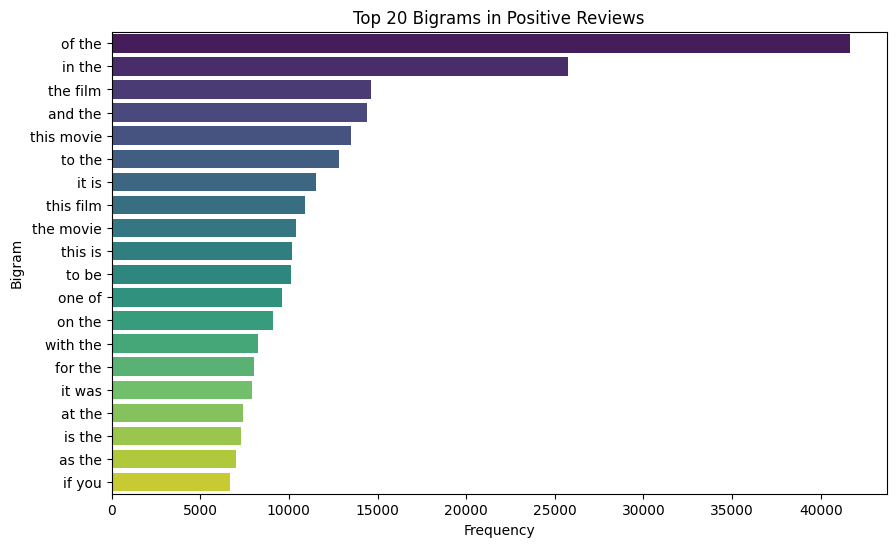

In [ ]:
bigram_df = pd.DataFrame(bigram_freq, columns=['Bigram', 'Frequency'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')
plt.title('Top 20 Bigrams in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

## **Data preparation**

### **Tokenizing data using NLTK and TorchText**

In [ ]:
#dwnloading punkt
nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.data.path.append('/root/nltk_data')

nltk_tokenizer = nltk.word_tokenize
torch_tokenizer = get_tokenizer("basic_english")

# Tokenizing using NLTK
start_time = time.time()
nltk_tokens = [nltk_tokenizer(review) for review in df['review']]
nltk_time = time.time() - start_time

# Tokenizing using TorchText
start_time = time.time()
torch_tokens = [torch_tokenizer(review) for review in df['review']]
torch_time = time.time() - start_time

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
print("NLTK Tokens (First Review):", nltk_tokens[0])
print("TorchText Tokens (First Review):", torch_tokens[0])

NLTK Tokens (First Review): ['Once', 'again', 'John', 'Madden', 'has', 'given', 'us', 'a', 'magnificent', 'film', '.', 'A', 'simple', 'but', 'beautiful', 'story', 'located', 'in', 'a', 'real', 'paradise', 'and', 'the', 'music', 'ca', "n't", 'be', 'better', ',', 'Stephen', 'Warbeck', 'delights', 'us', 'once', 'more', ',', 'and', 'good', 'actings', 'but', '.........', 'why', 'on', 'earth', 'is', 'Penelope', 'Cruz', 'in', 'this', 'film', '?', 'I', 'asked', 'myself', 'that', 'same', 'question', 'while', 'watching', 'this', 'movie', '.', 'Of', 'course', 'her', 'greek', 'accent', 'is', 'not', 'believable', ',', 'she', "'s", 'uncapable', 'of', 'acting', 'decently', 'not', 'even', 'in', 'one', 'scene', '.', 'Not', 'even', 'at', 'the', 'end', 'she', 'did', 'a', 'good', 'job', ',', 'after', 'so', 'many', 'events', ',', 'after', 'years', 'she', 'finally', 'gets', 'to', 'see', 'Corelli', 'again', 'and', 'she', 'could', "n't", 'change', 'the', 'same', 'face', 'of', 'stupidy', 'we', 'had', 'to', 'be

In [ ]:
# vocabulary for NLTK tokens
nltk_vocab = Counter()
for tokens in nltk_tokens:
    nltk_vocab.update(tokens)

# vocabulary for TorchText tokens
torch_vocab = Counter()
for tokens in torch_tokens:
    torch_vocab.update(tokens)

print("NLTK Vocabulary Size:", len(nltk_vocab))
print("TorchText Vocabulary Size:", len(torch_vocab))

print("NLTK Tokenization Time:", nltk_time)
print("TorchText Tokenization Time:", torch_time)

NLTK Vocabulary Size: 181614
TorchText Vocabulary Size: 147156
NLTK Tokenization Time: 87.0618588924408
TorchText Tokenization Time: 7.287423133850098


TorchText was faster and had a smaller vocabulary, but I chose NLTK because it handles punctuation and contractions better, giving more detailed results. Even though NLTK is slower, because of it's accuracy I chose NLTK.

### **Splitting Data**

In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset(df, train_size=0.8, val_size=0.1, test_size=0.1, random_state=42):
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=random_state)

    val_df, test_df = train_test_split(temp_df, test_size=test_size/(val_size + test_size), random_state=random_state)

    return train_df, val_df, test_df


train_df, val_df, test_df = split_dataset(df)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 40000
Validation set size: 5000
Test set size: 5000


In [ ]:
from torchtext.vocab import build_vocab_from_iterator
train_tokens = [nltk_tokenizer(review) for review in train_df['review']]
vocab = build_vocab_from_iterator(train_tokens, specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

#vocabulary size for traininng data
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 160790


### **Convert text data to numerical sequences using vocabulary**

In [ ]:
def text_to_sequence(tokens, vocab):
    return [vocab[token] for token in tokens]

train_sequences = [text_to_sequence(tokens, vocab) for tokens in train_tokens]
val_sequences = [text_to_sequence(nltk_tokenizer(review), vocab) for review in val_df['review']]
test_sequences = [text_to_sequence(nltk_tokenizer(review), vocab) for review in test_df['review']]

print("First training sequence:", train_sequences[0])

First training sequence: [57, 530, 12349, 414, 852, 6123, 174, 10, 2, 767, 4, 12349, 51, 107, 12, 168, 386, 4, 139, 2, 127, 174, 12, 557, 8, 1217, 9060, 3, 2, 16573, 115444, 84, 361, 51, 92, 2508, 4, 153, 2982, 6, 4060, 44, 76, 114, 578, 400, 386, 8, 3822, 4, 2342, 20876, 285, 636, 2879, 43, 33, 66, 2234, 2427, 4, 265, 2643, 3, 64, 14, 6, 32406, 45228, 10, 2, 11495, 54478, 13, 91, 755, 12349, 386, 1241, 87, 69, 79, 91, 167, 168, 10, 66, 5, 35828, 12349, 4, 136, 14, 38, 471, 4, 17, 45228, 9, 999, 987, 16035, 2666, 4, 20876, 5481, 38017, 4, 153, 14, 46, 6, 570, 4, 153, 150165, 9060, 3, 2510, 3, 801, 29, 11056, 692, 49, 18, 838, 49, 162, 3, 37, 14, 2803, 31, 680, 897, 4, 139, 2, 6792, 3, 38017, 6778, 3, 2135, 21, 80309, 84, 8, 955, 3, 955, 245, 168, 8, 95, 4, 20876, 1090, 8, 48125, 6, 48578, 9371, 5, 48480, 12, 19, 2747, 2427, 919, 174, 1557, 7, 2, 16035, 3, 10, 2, 1983, 7, 182, 168, 10, 66, 5, 815, 15, 251, 2427, 8, 3926, 12349, 8, 2, 32406, 45228, 4, 283, 79, 287, 168, 10, 66, 5, 10275,

### **Padding Sequences to uniform length**

In [ ]:
sequence_lengths = [len(seq) for seq in train_sequences]
max_length = int(np.percentile(sequence_lengths, 95))
print(f"Maximum sequence length (95th percentile): {max_length}")

def pad_sequences(sequences, max_length, pad_value):
    return pad_sequence([torch.tensor(seq[:max_length] + [pad_value] * max(0, max_length - len(seq))) for seq in sequences], batch_first=True, padding_value=pad_value)

pad_value = vocab["<pad>"]
train_padded = pad_sequences(train_sequences, max_length, pad_value)
val_padded = pad_sequences(val_sequences, max_length, pad_value)
test_padded = pad_sequences(test_sequences, max_length, pad_value)

print("First padded training sequence:", train_padded[0])

Maximum sequence length (95th percentile): 675
First padded training sequence: tensor([    57,    530,  12349,    414,    852,   6123,    174,     10,      2,
           767,      4,  12349,     51,    107,     12,    168,    386,      4,
           139,      2,    127,    174,     12,    557,      8,   1217,   9060,
             3,      2,  16573, 115444,     84,    361,     51,     92,   2508,
             4,    153,   2982,      6,   4060,     44,     76,    114,    578,
           400,    386,      8,   3822,      4,   2342,  20876,    285,    636,
          2879,     43,     33,     66,   2234,   2427,      4,    265,   2643,
             3,     64,     14,      6,  32406,  45228,     10,      2,  11495,
         54478,     13,     91,    755,  12349,    386,   1241,     87,     69,
            79,     91,    167,    168,     10,     66,      5,  35828,  12349,
             4,    136,     14,     38,    471,      4,     17,  45228,      9,
           999,    987,  16035,   2666,  

In [ ]:
# labels to tensors
train_labels = torch.tensor(train_df['label'].values, dtype=torch.long)
val_labels = torch.tensor(val_df['label'].values, dtype=torch.long)
test_labels = torch.tensor(test_df['label'].values, dtype=torch.long)

print("First few training labels:", train_labels[:5])

First few training labels: tensor([1, 1, 0, 0, 1])


### **Discuss the impact of padding and truncation on model performance. If you truncate very long sequences, you might lose important information. If you pad excessively, you might introduce noise.**

  Truncating very long sequences might remove important information, especially if key details are at the end of the text. On the other hand, excessive padding can introduce noise, as the model might focus on irrelevant padded values, reducing its efficiency. Balancing the sequence length is crucial to ensure the model captures meaningful information without unnecessary noise.

# **Baseline LSTM Model**

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.Sigmoid()

    def forward(self, text):


        embedded = self.embedding(text)

        lstm_output, (hidden_state, cell_state) = self.lstm(embedded)

        lstm_output = self.dropout(lstm_output)

        final_hidden_state = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)

        fc1_output = torch.relu(self.fc1(final_hidden_state))
        fc2_output = self.fc2(fc1_output)


        output = self.activation(fc2_output)

        return output

vocab_size = len(vocab)
embedding_dim = 200
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout_rate = 0.5

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_rate)
summary(model, input_size=(32, max_length), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─Embedding: 1-1                         [32, 675, 200]            32,158,000
├─LSTM: 1-2                              [32, 675, 256]            1,128,448
├─Dropout: 1-3                           [32, 675, 256]            --
├─Linear: 1-4                            [32, 128]                 32,896
├─Linear: 1-5                            [32, 1]                   129
├─Sigmoid: 1-6                           [32, 1]                   --
Total params: 33,319,473
Trainable params: 33,319,473
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 25.40
Input size (MB): 0.17
Forward/backward pass size (MB): 78.83
Params size (MB): 133.28
Estimated Total Size (MB): 212.28

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()

            predicted = (outputs.squeeze() > 0.5).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy * 100:.2f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy * 100:.2f}, "
              f"Time: {epoch_time:.2f}s")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()

            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

### **Training model**

In [ ]:
# Hyperparameter combinations
learning_rates = [0.0001, 0.0005]
batch_sizes = [32, 64]
hidden_dims = [64,128]
dropout_rates = [0.5]
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hidden_dim in hidden_dims:
            for dropout_rate in dropout_rates:
                print(f"\nTraining with: LR={lr}, Batch Size={batch_size}, "
                      f"Hidden Dim={hidden_dim}, Dropout Rate={dropout_rate}")

                train_dataset = TensorDataset(train_padded, train_labels)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                val_dataset = TensorDataset(val_padded, val_labels)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_rate).to(device)

                criterion = nn.BCELoss()
                optimizer = optim.AdamW(model.parameters(), lr=lr)

                train_losses, train_accuracies, val_losses, val_accuracies = train_model(
                    model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

                results.append({
                    "lr": lr,
                    "batch_size": batch_size,
                    "hidden_dim": hidden_dim,
                    "dropout_rate": dropout_rate,
                    "train_losses": train_losses,
                    "train_accuracies": train_accuracies,
                    "val_losses": val_losses,
                    "val_accuracies": val_accuracies
                })


Training with: LR=0.0001, Batch Size=32, Hidden Dim=64, Dropout Rate=0.5
Epoch [1/5], Train Loss: 0.6739, Train Acc: 57.12, Val Loss: 0.6875, Val Acc: 52.00, Time: 46.94s
Epoch [2/5], Train Loss: 0.6371, Train Acc: 64.10, Val Loss: 0.6800, Val Acc: 57.00, Time: 47.26s
Epoch [3/5], Train Loss: 0.5853, Train Acc: 69.41, Val Loss: 0.5750, Val Acc: 72.02, Time: 48.66s
Epoch [4/5], Train Loss: 0.5063, Train Acc: 76.37, Val Loss: 0.5276, Val Acc: 73.42, Time: 47.25s
Epoch [5/5], Train Loss: 0.4588, Train Acc: 79.71, Val Loss: 0.6002, Val Acc: 71.54, Time: 49.18s

Training with: LR=0.0001, Batch Size=32, Hidden Dim=128, Dropout Rate=0.5
Epoch [1/5], Train Loss: 0.6437, Train Acc: 61.66, Val Loss: 0.5716, Val Acc: 71.48, Time: 115.81s
Epoch [2/5], Train Loss: 0.5437, Train Acc: 73.69, Val Loss: 0.4937, Val Acc: 77.28, Time: 116.98s
Epoch [3/5], Train Loss: 0.4963, Train Acc: 76.79, Val Loss: 0.4697, Val Acc: 78.98, Time: 117.05s
Epoch [4/5], Train Loss: 0.4406, Train Acc: 80.37, Val Loss: 0.4

In [ ]:
# Finding the best hyperparameter combination based on validation accuracy
best_result = max(results, key=lambda x: x["val_accuracies"][-1])

print("Best Hyperparameter Combination:")
print(f"Learning Rate (LR): {best_result['lr']}")
print(f"Batch Size (BS): {best_result['batch_size']}")
print(f"Hidden Dimension (HD): {best_result['hidden_dim']}")
print(f"Dropout Rate (DR): {best_result['dropout_rate']}")
print(f"Final Training Accuracy: {best_result['train_accuracies'][-1]:.4f}")
print(f"Final Validation Accuracy: {best_result['val_accuracies'][-1]:.4f}")
print(f"Final Training Loss: {best_result['train_losses'][-1]:.4f}")
print(f"Final Validation Loss: {best_result['val_losses'][-1]:.4f}")

Best Hyperparameter Combination:
Learning Rate (LR): 0.0005
Batch Size (BS): 32
Hidden Dimension (HD): 128
Dropout Rate (DR): 0.5
Final Training Accuracy: 0.9212
Final Validation Accuracy: 0.8926
Final Training Loss: 0.2049
Final Validation Loss: 0.2797


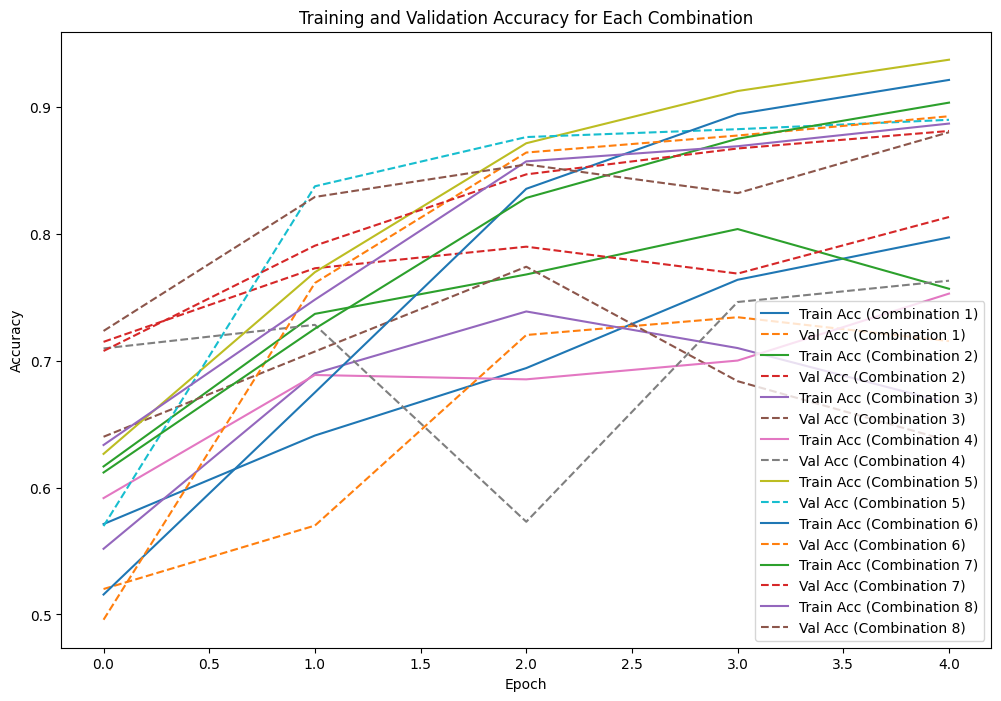

In [ ]:
# Plotting training and validation accuracy for each combination
plt.figure(figsize=(12, 8))
for i, result in enumerate(results):
    plt.plot(result["train_accuracies"], label=f"Train Acc (Combination {i+1})")
    plt.plot(result["val_accuracies"], label=f"Val Acc (Combination {i+1})", linestyle="--")
plt.title("Training and Validation Accuracy for Each Combination")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

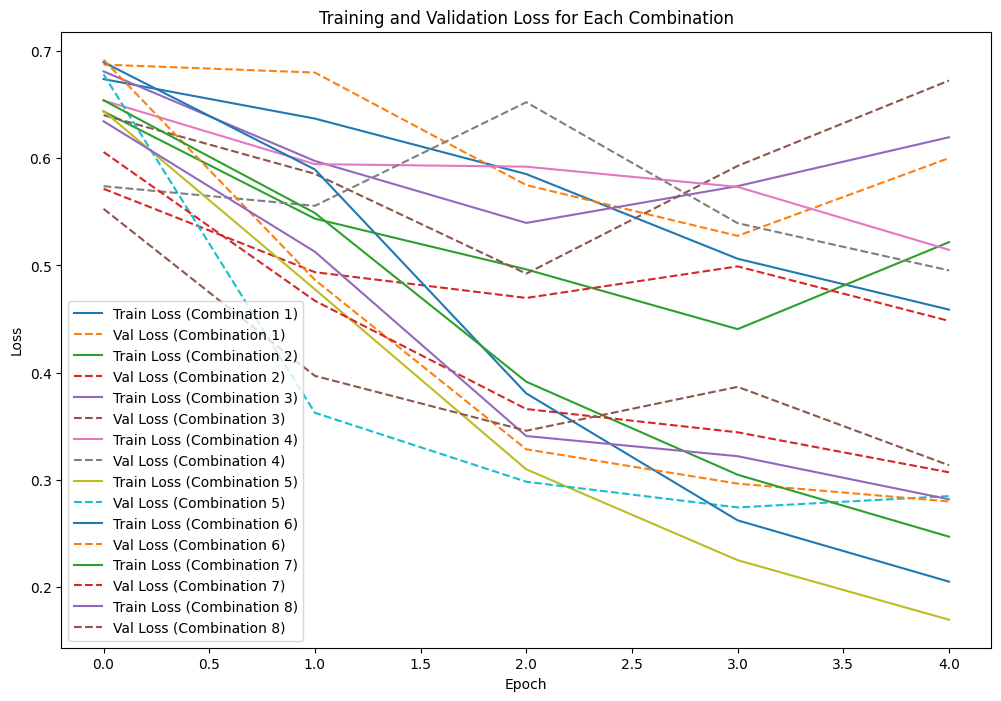

In [ ]:
# Plotting training and validation loss for each combination
plt.figure(figsize=(12, 8))
for i, result in enumerate(results):
    plt.plot(result["train_losses"], label=f"Train Loss (Combination {i+1})")
    plt.plot(result["val_losses"], label=f"Val Loss (Combination {i+1})", linestyle="--")
plt.title("Training and Validation Loss for Each Combination")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

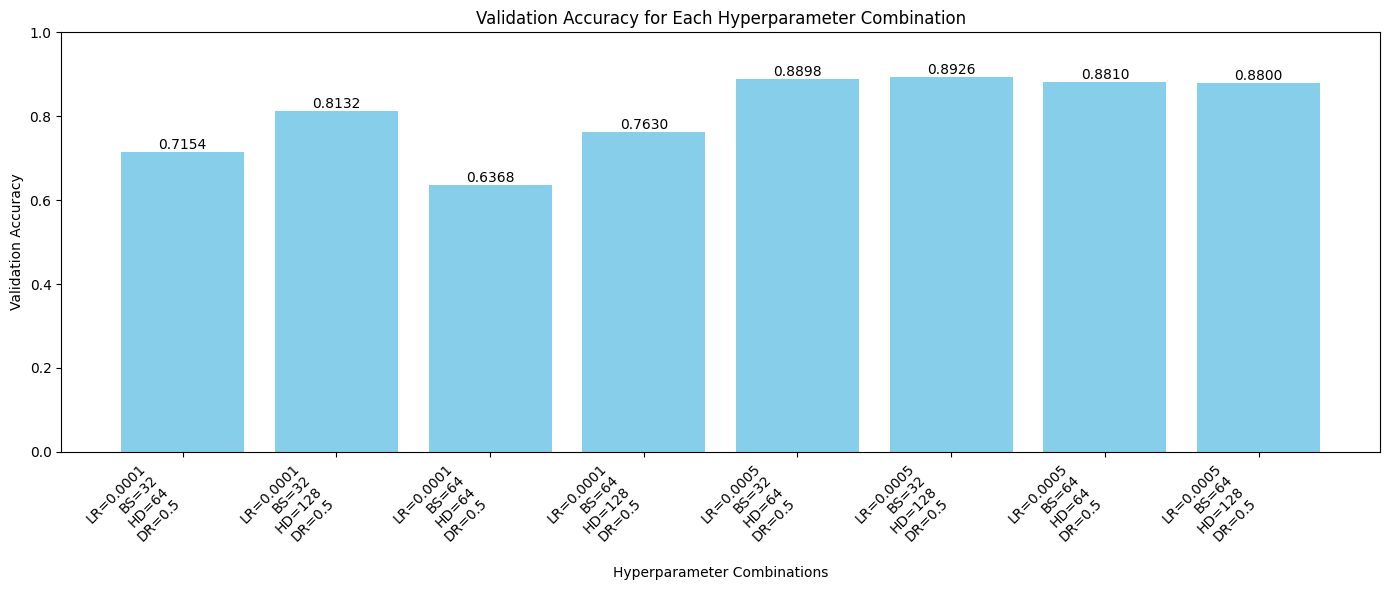

In [ ]:
#validation accuracy comparision plot
combinations = []
val_accs = []

for result in results:
    lr = result["lr"]
    batch_size = result["batch_size"]
    hidden_dim = result["hidden_dim"]
    dropout_rate = result["dropout_rate"]
    val_acc = result["val_accuracies"][-1]
    combination_label = f"LR={lr}\nBS={batch_size}\nHD={hidden_dim}\nDR={dropout_rate}"
    combinations.append(combination_label)
    val_accs.append(val_acc)


plt.figure(figsize=(14, 6))
bars = plt.bar(combinations, val_accs, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}", ha='center', va='bottom')

plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Each Hyperparameter Combination")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### **Evaluating model**

In [ ]:
best_lr = best_result["lr"]
best_batch_size = best_result["batch_size"]
best_hidden_dim = best_result["hidden_dim"]
best_dropout_rate = best_result["dropout_rate"]

best_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout_rate=best_dropout_rate
).to(device)


criterion = nn.BCELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_lr)

train_dataset = TensorDataset(train_padded, train_labels)
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)

val_dataset = TensorDataset(val_padded, val_labels)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    best_model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

test_dataset = TensorDataset(test_padded, test_labels)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

test_loss, test_accuracy = evaluate_model(best_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}")


Epoch [1/5], Train Loss: 0.6556, Train Acc: 60.18, Val Loss: 0.6121, Val Acc: 68.70, Time: 112.52s
Epoch [2/5], Train Loss: 0.5157, Train Acc: 75.41, Val Loss: 0.4380, Val Acc: 79.44, Time: 113.31s
Epoch [3/5], Train Loss: 0.3889, Train Acc: 83.09, Val Loss: 0.3865, Val Acc: 82.90, Time: 113.87s
Epoch [4/5], Train Loss: 0.3264, Train Acc: 86.34, Val Loss: 0.3216, Val Acc: 86.46, Time: 113.60s
Epoch [5/5], Train Loss: 0.2543, Train Acc: 89.74, Val Loss: 0.2814, Val Acc: 88.50, Time: 113.63s
Test Loss: 0.2969, Test Accuracy: 87.66


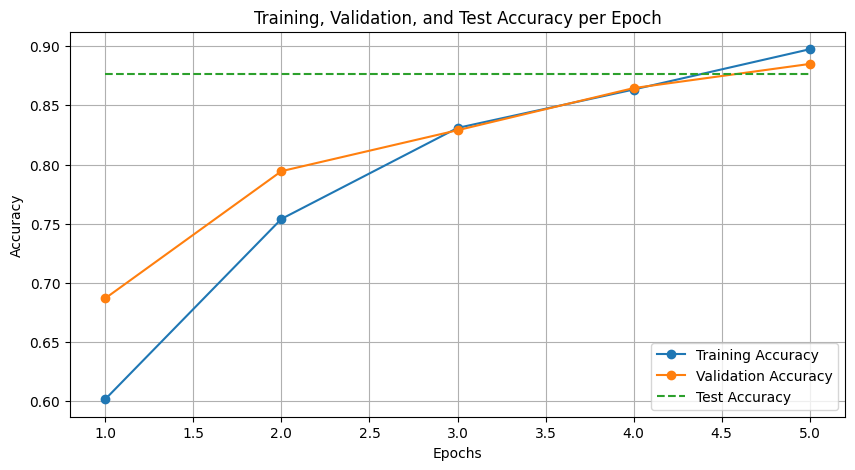

In [ ]:
#accuracy plot
test_accuracies = [test_accuracy] * num_epochs
test_losses = [test_loss] * num_epochs

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy per Epoch")
plt.legend()
plt.grid()
plt.show()


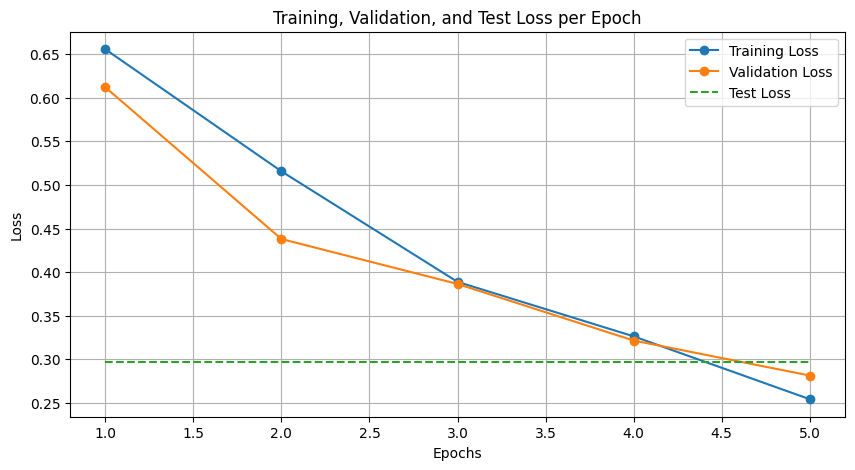

In [ ]:
#loss plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

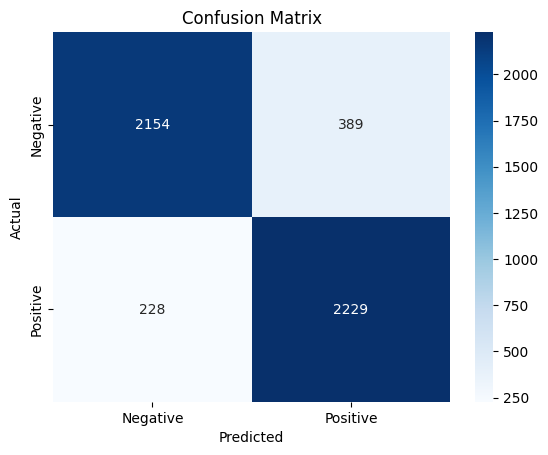

Precision: 0.8514, Recall: 0.9072, F1-Score: 0.8784


In [ ]:
# confusion matrix
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

In [ ]:
# Saving the best model
torch.save(best_model.state_dict(), "best_base_lstm_model.pth")

In [ ]:
from google.colab import files
files.download('best_base_lstm_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Improved LSTM**

In [ ]:
class ImprovedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, dropout_rate, pretrained_embeddings=None):
        super(ImprovedLSTMModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings, requires_grad=False)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)

        lstm_output, (hidden_state, cell_state) = self.lstm(embedded)

        lstm_output = self.dropout(lstm_output)
        final_hidden_state = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)

        fc1_output = torch.relu(self.fc1(final_hidden_state))
        fc2_output = self.fc2(fc1_output)

        output = self.activation(fc2_output)

        return output



In [ ]:
# Loading pre-trained GloVe embeddings
from torchtext.vocab import GloVe
glove = GloVe(name='6B', dim=200)

pretrained_embeddings = torch.zeros((vocab_size, 200))
for word, idx in vocab.get_stoi().items():
    if word in glove.stoi:
        pretrained_embeddings[idx] = torch.tensor(glove[word])

In [ ]:
vocab_size = len(vocab)
embedding_dim = 200
hidden_dim = 128
num_layers = 3
output_dim = 1
dropout_rate = 0.5

improved_model = ImprovedLSTMModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout_rate=dropout_rate,
    pretrained_embeddings=pretrained_embeddings
).to(device)

summary(improved_model, input_size=(32, max_length), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
ImprovedLSTMModel                        [32, 1]                   --
├─Embedding: 1-1                         [32, 675, 200]            (32,158,000)
├─LSTM: 1-2                              [32, 675, 256]            1,128,448
├─Dropout: 1-3                           [32, 675, 256]            --
├─Linear: 1-4                            [32, 128]                 32,896
├─Linear: 1-5                            [32, 1]                   129
├─Sigmoid: 1-6                           [32, 1]                   --
Total params: 33,319,473
Trainable params: 1,161,473
Non-trainable params: 32,158,000
Total mult-adds (Units.GIGABYTES): 25.40
Input size (MB): 0.17
Forward/backward pass size (MB): 78.83
Params size (MB): 133.28
Estimated Total Size (MB): 212.28

In [ ]:
learning_rates = [0.0001, 0.0005]
batch_sizes = [32]
hidden_dims = [64,128]
dropout_rate = 0.5
num_epochs = 5

results_improved = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for hidden_dim in hidden_dims:
            print(f"\nTraining Improved Model with: LR={lr}, Batch Size={batch_size}, Hidden Dim={hidden_dim}, Dropout Rate={dropout_rate}")

            train_dataset = TensorDataset(train_padded, train_labels)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_dataset = TensorDataset(val_padded, val_labels)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            improved_model = ImprovedLSTMModel(
                vocab_size=vocab_size,
                embedding_dim=embedding_dim,
                hidden_dim=hidden_dim,
                num_layers=num_layers,
                output_dim=output_dim,
                dropout_rate=dropout_rate,
                pretrained_embeddings=pretrained_embeddings
            ).to(device)

            criterion = nn.BCELoss()
            optimizer = optim.AdamW(improved_model.parameters(), lr=lr)

            train_losses, train_accuracies, val_losses, val_accuracies = train_model(
                improved_model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

            results_improved.append({
                "lr": lr,
                "batch_size": batch_size,
                "hidden_dim": hidden_dim,
                "train_losses": train_losses,
                "train_accuracies": train_accuracies,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies
            })


Training Improved Model with: LR=0.0001, Batch Size=32, Hidden Dim=64, Dropout Rate=0.5
Epoch [1/5], Train Loss: 0.6727, Train Acc: 57.75, Val Loss: 0.6720, Val Acc: 56.76, Time: 30.83s
Epoch [2/5], Train Loss: 0.6286, Train Acc: 65.20, Val Loss: 0.5577, Val Acc: 72.58, Time: 30.72s
Epoch [3/5], Train Loss: 0.5732, Train Acc: 71.12, Val Loss: 0.5615, Val Acc: 71.14, Time: 30.61s
Epoch [4/5], Train Loss: 0.5667, Train Acc: 71.07, Val Loss: 0.5707, Val Acc: 73.52, Time: 30.73s
Epoch [5/5], Train Loss: 0.5253, Train Acc: 74.87, Val Loss: 0.4693, Val Acc: 79.40, Time: 30.78s

Training Improved Model with: LR=0.0001, Batch Size=32, Hidden Dim=128, Dropout Rate=0.5
Epoch [1/5], Train Loss: 0.6469, Train Acc: 61.86, Val Loss: 0.5376, Val Acc: 72.96, Time: 97.62s
Epoch [2/5], Train Loss: 0.5294, Train Acc: 75.00, Val Loss: 0.4544, Val Acc: 80.26, Time: 98.42s
Epoch [3/5], Train Loss: 0.5055, Train Acc: 76.12, Val Loss: 0.4078, Val Acc: 82.44, Time: 99.12s
Epoch [4/5], Train Loss: 0.5730, Trai

In [ ]:
# Finding the best hyperparameter combination for the improved model
best_result_improved = max(results_improved, key=lambda x: x["val_accuracies"][-1])

print("Best Hyperparameter Combination for Improved Model:")
print(f"Learning Rate (LR): {best_result_improved['lr']}")
print(f"Batch Size (BS): {best_result_improved['batch_size']}")
print(f"Hidden Dimension (HD): {best_result_improved['hidden_dim']}")
print(f"Final Training Accuracy: {best_result_improved['train_accuracies'][-1]:.4f}")
print(f"Final Validation Accuracy: {best_result_improved['val_accuracies'][-1]:.4f}")
print(f"Final Training Loss: {best_result_improved['train_losses'][-1]:.4f}")
print(f"Final Validation Loss: {best_result_improved['val_losses'][-1]:.4f}")

Best Hyperparameter Combination for Improved Model:
Learning Rate (LR): 0.0005
Batch Size (BS): 32
Hidden Dimension (HD): 128
Final Training Accuracy: 0.8644
Final Validation Accuracy: 0.8698
Final Training Loss: 0.3264
Final Validation Loss: 0.3254


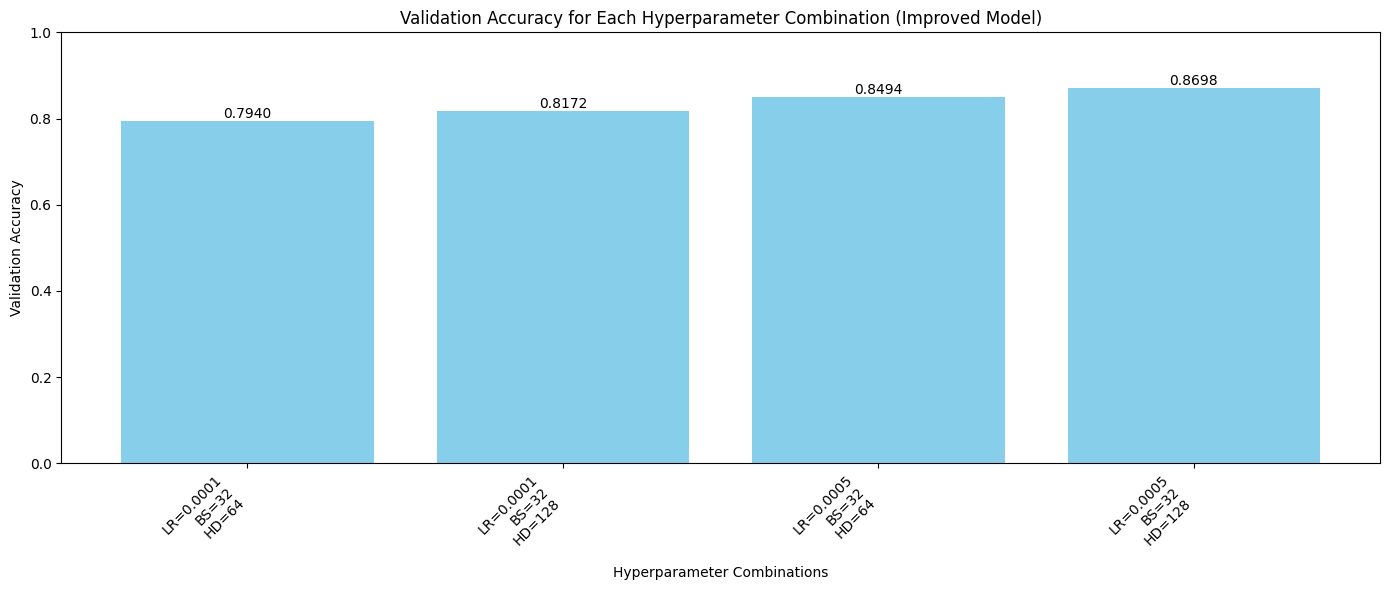

In [ ]:
combinations_improved = []
val_accs_improved = []

for result in results_improved:
    lr = result["lr"]
    batch_size = result["batch_size"]
    hidden_dim = result["hidden_dim"]
    val_acc = result["val_accuracies"][-1]

    combination_label = f"LR={lr}\nBS={batch_size}\nHD={hidden_dim}"
    combinations_improved.append(combination_label)
    val_accs_improved.append(val_acc)

plt.figure(figsize=(14, 6))
bars = plt.bar(combinations_improved, val_accs_improved, color='skyblue')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}", ha='center', va='bottom')


plt.xlabel("Hyperparameter Combinations")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Each Hyperparameter Combination (Improved Model)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
best_lr_improved = best_result_improved["lr"]
best_batch_size_improved = best_result_improved["batch_size"]
best_hidden_dim_improved = best_result_improved["hidden_dim"]

best_improved_model = ImprovedLSTMModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=best_hidden_dim_improved,
    num_layers=num_layers,
    output_dim=output_dim,
    dropout_rate=dropout_rate,
    pretrained_embeddings=pretrained_embeddings
).to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(best_improved_model.parameters(), lr=best_lr_improved)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    best_improved_model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

test_loss_improved, test_accuracy_improved = evaluate_model(best_improved_model, test_loader, criterion, device)
print(f"Test Loss (Improved Model): {test_loss_improved:.4f}, Test Accuracy (Improved Model): {test_accuracy_improved * 100:.2f}%")

Epoch [1/5], Train Loss: 0.6727, Train Acc: 56.93, Val Loss: 0.6395, Val Acc: 70.86, Time: 99.25s
Epoch [2/5], Train Loss: 0.4827, Train Acc: 76.92, Val Loss: 0.3416, Val Acc: 85.78, Time: 100.34s
Epoch [3/5], Train Loss: 0.3424, Train Acc: 85.24, Val Loss: 0.2980, Val Acc: 87.84, Time: 99.71s
Epoch [4/5], Train Loss: 0.2977, Train Acc: 87.48, Val Loss: 0.2830, Val Acc: 88.34, Time: 99.81s
Epoch [5/5], Train Loss: 0.2777, Train Acc: 88.41, Val Loss: 0.2674, Val Acc: 89.08, Time: 99.69s
Test Loss (Improved Model): 0.2666, Test Accuracy (Improved Model): 89.16%


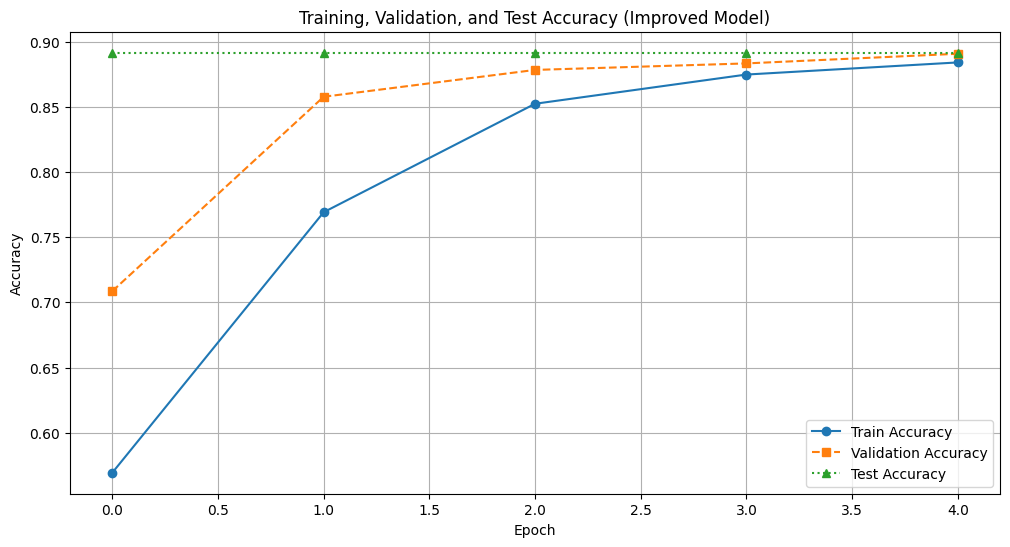

In [ ]:
#accuracy plot for improved model
test_accuracies = [test_accuracy_improved] * num_epochs

plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.plot(val_accuracies, label="Validation Accuracy", linestyle="--", marker='s')
plt.plot(test_accuracies, label="Test Accuracy", linestyle=":", marker='^')
plt.title("Training, Validation, and Test Accuracy (Improved Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

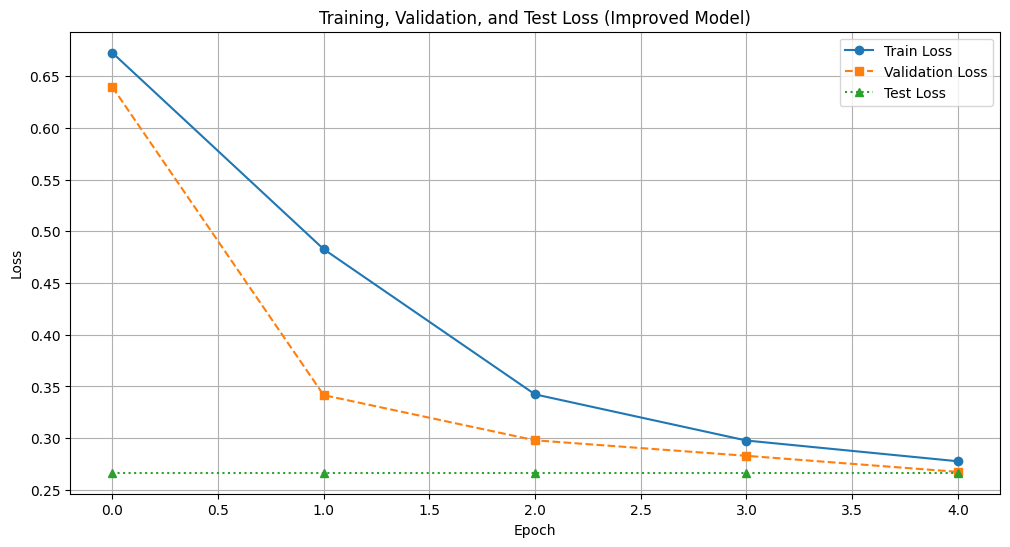

In [ ]:
#loss plot for improved model
test_losses = [test_loss_improved] * num_epochs


plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", linestyle="--", marker='s')
plt.plot(test_losses, label="Test Loss", linestyle=":", marker='^')
plt.title("Training, Validation, and Test Loss (Improved Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

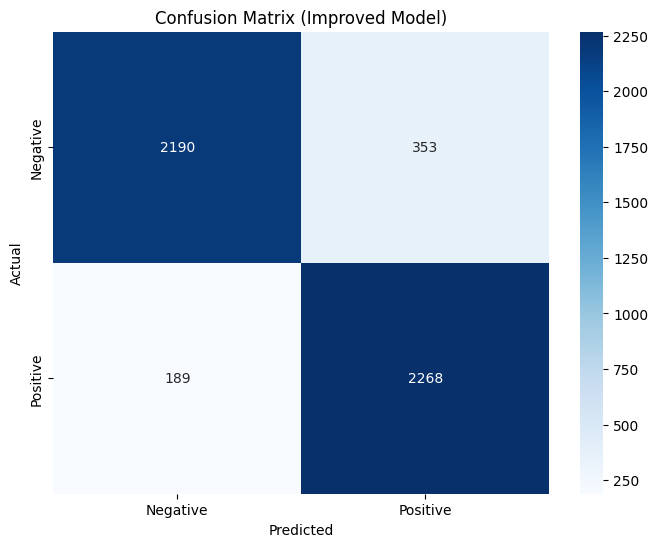

Precision: 0.8653, Recall: 0.9231, F1-Score: 0.8933


In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_improved_model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix (Improved Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

In [ ]:
# Saving the best improved model
torch.save(best_improved_model.state_dict(), "best_improved_lstm_model.pth")

In [ ]:
from google.colab import files
files.download('best_improved_lstm_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test Accuracy (Base Model): 87.66%
Test Accuracy (Improved Model): 89.16%


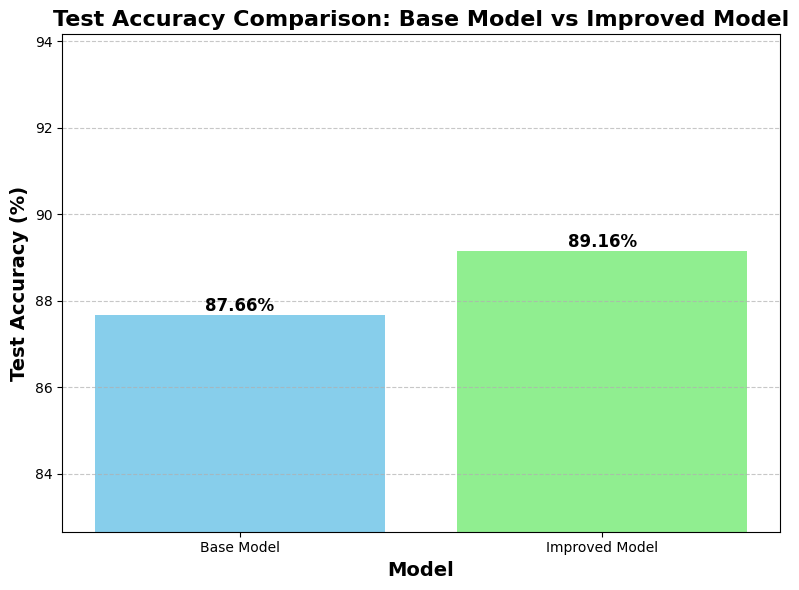

In [ ]:
test_accuracy_base = test_accuracy * 100
test_accuracy_improved = test_accuracy_improved
print(f"Test Accuracy (Base Model): {test_accuracy_base:.2f}%")
print(f"Test Accuracy (Improved Model): {test_accuracy_improved:.2f}%")

models = ["Base Model", "Improved Model"]
test_accuracies = [test_accuracy_base, test_accuracy_improved]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, test_accuracies, color=['skyblue', 'lightgreen'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Model", fontsize=14, fontweight='bold')
plt.ylabel("Test Accuracy (%)", fontsize=14, fontweight='bold')
plt.title("Test Accuracy Comparison: Base Model vs Improved Model", fontsize=16, fontweight='bold')

plt.ylim(min(test_accuracies) - 5, max(test_accuracies) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Discussion**

## **1. Briefly describe the dataset and its key characteristics.**

The Stanford Large Movie Review Dataset (IMDb) is a collection of 50,000 movie reviews from IMDb, labeled as either positive (1) or negative (0) sentiment. It is split into 25,000 training samples and 25,000 test samples, making it balanced for binary classification. Key characteristics include:


*   Average review length: ~235 words.
*   Vocabulary size: ~148,585 unique words.
*   No missing values, ensuring clean data for analysis and modeling. The dataset is widely used for sentiment analysis tasks in NLP.











## **2. Describe both your baseline and improved LSTM architectures in detail.**

**Baseline LSTM Model:**

The baseline LSTM model consists of:


*   Embedding Layer: Converts word indices into dense vectors of size 200.
*   LSTM Layers: Three LSTM layers with 128 hidden units each. Dropout is applied between layers to prevent overfitting.
*   Fully Connected Layers: Two linear layers map the LSTM output to a single output unit.
*   Sigmoid Activation: Converts the output to a probability between 0 and 1 for binary classification.
*   The model has 33.3 million parameters, with most parameters in the embedding layer. It processes sequences of length 675 (padded) and outputs a single sentiment prediction.

**Improved LSTM Model**

The improved LSTM model enhances the baseline with:

*   Pre-trained GloVe Embeddings: Uses 200-dimensional GloVe vectors to initialize the embedding layer, which are frozen during training.
*   Bidirectional LSTM: The LSTM layers are bidirectional, capturing context from both past and future words.
*   Reduced Trainable Parameters: Only 1.16 million parameters are trainable, as the embedding layer is frozen.
*   The improved model has the same structure as the baseline but leverages pre-trained embeddings and bidirectional processing for better performance. It also processes sequences of length 675 and outputs a single sentiment prediction.

**Key Differences**

1.   Embeddings: Baseline uses random embeddings, while the improved model uses pre-trained GloVe embeddings.
2.   Bidirectional LSTM: Improved model uses bidirectional LSTM for better context understanding.
3.   Trainable Parameters: Improved model has fewer trainable parameters due to frozen embeddings.


## **3. Discuss the results, comparing the performance of the baseline and improved models. Refer to specific metrics and visualizations.**

**Comparison of Baseline and Improved LSTM Models**

**Baseline LSTM Model**


*   Best Hyperparameters: Learning rate = 0.0005, Batch size = 32, Hidden dimension = 128, Dropout rate = 0.5.
*  Training Accuracy: 92.12%
*  Validation Accuracy: 89.26%
*   Test Accuracy: 87.66%
*   Training Loss: 0.2049
*   Validation Loss: 0.2797

The baseline model performed well, achieving 87.66% test accuracy. However, there was a noticeable gap between training and validation accuracy, indicating slight overfitting.

**Improved LSTM Model**


*   Best Hyperparameters: Learning rate = 0.0005, Batch size = 32, Hidden dimension = 128.
*   Test Accuracy: 89.16%

The improved model, with pre-trained GloVe embeddings and bidirectional LSTM, achieved a higher test accuracy of 89.16%. It also showed better generalization, with training and validation accuracy closer together, reducing overfitting.

**Key Observations**

*   Improved Test Accuracy: The improved model outperformed the baseline by 1.5% on test accuracy.
*   Better Generalization: The improved model had a smaller gap between training and validation accuracy, indicating less overfitting.
*   Faster Convergence: The improved model achieved higher validation accuracy earlier in training, showing better learning efficiency.

Overall, the improved model performed better due to the use of pre-trained embeddings and bidirectional LSTM, which helped capture more meaningful patterns in the data.

## **4. Discuss the strengths and limitations of using recurrent neural models (specifically LSTMs) for sentiment analysis.**

**Strengths and Limitations of LSTMs for Sentiment Analysis**

**Strengths:**


*   Handling Long Sequences: LSTMs are good at capturing long-term dependencies in text, making them effective for analyzing long reviews where sentiment might depend on context spread across many words.
*   Context Understanding: They can understand the context of words in a sequence, which is crucial for sentiment analysis.
*   Flexibility: LSTMs can be improved with techniques like bidirectional layers and pre-trained embeddings, enhancing their performance.

**Limitations:**

*   Computational Cost: LSTMs are slower and require more resources to train compared to simpler models like logistic regression, especially for large datasets.
*   Interpretability: LSTMs are harder to interpret than models like logistic regression, where you can directly see the importance of each feature.
*   Sensitivity to Hyperparameters: LSTMs require careful tuning of hyperparameters (e.g., learning rate, hidden units, dropout) to perform well, which can be time-consuming.
*   Overfitting: Without proper regularization (e.g., dropout), LSTMs can overfit to the training data, especially with smaller datasets.

In summary, LSTMs are powerful for sentiment analysis but has higher computational costs and complexity compared to simpler models.

## **5. References**

1.   https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
2.   https://nlp.stanford.edu/projects/glove/
3.   https://pytorch.org/tutorials/
4.   https://pytorch.org/text/stable/
5.   https://www.nltk.org/install.html
6.   https://www.geeksforgeeks.org/understanding-of-lstm-networks/
7.   https://www.datacamp.com/tutorial/wordcloud-python
8.   https://scikit-learn.org/stable/api/index.html
